# GALAH DR4 Stellar Label Optimisation Binaries

This script is used to find the optimal set of stellar labels for GALAH spectra in combination with non-spectroscopic information

The code is maintained at
https://github.com/svenbuder/GALAH_DR4
and described at
https://github.com/svenbuder/galah_dr4_paper

Author(s): Sven Buder (ANU, ASTRO 3D)

History:  
220824: Created

In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as c
import logging
import time
import os
import copy
import sys
from pathlib import Path
import pickle
import astropy.units as u
from astropy.table import Table
import scipy.interpolate
from scipy import signal
from scipy.spatial import cKDTree
import scipy.optimize as op
from scipy.ndimage.filters import convolve
from scipy.io import readsav
from scipy.optimize import curve_fit
import emcee
import corner

In [2]:
start_time = time.time()

In [3]:
if sys.argv[1] != '-f':
    sobject_id = int(sys.argv[1])
else:

#     sobject_id = 140810002201339 # Binary!
    sobject_id = 140806001701062 # Binary star with split lines...
#     sobject_id = 150830006601013 # Binary
#     sobject_id = 150831006001335 # Binary in NIR
#     sobject_id = 151227004201013 # Binary
#     sobject_id = 131217003901059 # Binary
#     sobject_id = 131217003901163 # Binary
#     sobject_id = 140111002601019 # Binary
#     sobject_id = 140111002601065 # Binary
#     sobject_id = 140112002801065 # Binary
#     sobject_id = 140209002701244 # Binary
#     sobject_id = 140209002701258 # Binary
    sobject_id = 131216001101026
    sobject_id = 131216001101030 # Not a binary, but inconsistent RV dr60 and Gaia
    sobject_id = 140115003101030
    sobject_id = 170806004701208 # Significant difference RV dr60 and Gaia
    sobject_id = 150603002801355 # Significant difference RV dr60 and Gaia
    sobject_id = 200907005101005 # Binary with different RV
    sobject_id = 200926003601272 # Binary with emission
    sobject_id = 131217003901101 # Binary
    sobject_id = 140409003001336 # Binary
    sobject_id = 140111002101195 # Hot star / potential binary, because Gaia RV different
    sobject_id = 140809004901383 # Binary turnoff star
    sobject_id = 200214003001072 # Binary RC star
    sobject_id = 140707000601023 # Binary RC Star
    sobject_id = 150429003101026 # Binary RC Star
    sobject_id = 140814003801018 # Binary RGB Star
    sobject_id = 200714001301029 # possible binary RGB - bad spectrum
    sobject_id = 220420002601108 # possible binary RGB - bad spectrum
    sobject_id = 220217003301219 # possible binary RGB - bad spectrum
    sobject_id = 140810004201274 # Binary TO Star
    sobject_id = 140814004801381 # Binary TO Star with emission
    sobject_id = 210523002601013 # 
    sobject_id = 131216001101122 # Binary
    sobject_id = 161213002601110 # Binary
    sobject_id = 140303002001275 # Potential Binary in OmegaCen
    sobject_id = 190614005601293 # binary
    sobject_id = 180130002801368 # Binary
    sobject_id = 131216001601054 # Binary
    sobject_id = 131216002101139 # Binary
    sobject_id = 131216001101059 # Binary
    sobject_id = 210325001601082 # possible binary
    sobject_id = 170220004101078 # possible binary
    sobject_id = 150703004101373 # Binary
    sobject_id = 161013004901145 # possible binary
    sobject_id = 140316004601011 # Possible Binary
    sobject_id = 150901003001265 # Possible Binary
    sobject_id = 170806005801391 # Binary
    sobject_id = 131216001601338 # Possible Binary
    sobject_id = 131216001101236 # Binary
    sobject_id = 131216001101015 # Possible Binary
    sobject_id = 170806005801391 # Possible Binary
    sobject_id = 210325001601082 # Possible Binary
    sobject_id = 141231004001024 # Binary
    sobject_id = 131216001101015 # Binary Traven
    sobject_id = 150427004301373 # Binary Traven
    sobject_id = 150411002601326 # Binary Traven
    
#     sobject_id = 210115002201239 # VESTA

    sobject_id = 200926003601272 # Binary stars; see email from 220909
    
neglect_ir_beginning = True
    
print('sobject_id: ',sobject_id)

debug = False

if os.path.exists('/avatar'):
    working_directory = '/avatar/buder/GALAH_DR4/'
else:
    working_directory = '/Users/svenbuder/GALAH_DR4/'
spectra_directory = working_directory+'observations/'

model_directory = working_directory+'spectrum_interpolation/ThePayne/models/'
from The_Payne import spectral_model

sobject_id:  200926003601272


# Get observation and initial parameters

In [4]:
flag_sp = int(0)

In [5]:
def get_reduction_products(sobject_id, neglect_ir_beginning=True):

    """
    This function collects the spectrum and other reduction products.
    
    INPUT:
    sobject_id: identifier for spectra
    neglect_ir_beginning: Cut away CCD4 information below 7700Å?

    OUTPUT:
    spectrum - dictionary with the following keywords:
    - sobject_id: identifier for GALAH
    - tmass_id: identifier for 2MASS
    - gaia_edr3_source_id: identifier for GaiaEDR3
    - init_teff: Teff value suggested by reduction
    - init_logg: logg value suggested by reduction
    - init_fe_h: [Fe/H] value suggested by reduction
    - init_x_fe: [X/Fe] for alpha-process elements C, O, Mg, Si, Ca, Ti
    - init_vmic: vmic value suggested by reduction
    - init_vsini: vsini value suggested by reduction
    - init_vrad: vrad value suggested by reduction

    """
    spectrum = dict()

    spectrum['sobject_id'] = sobject_id

    fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')

    spectrum['galah_id'] = fits_file[0].header['GALAH_ID']
    spectrum['tmass_id'] = fits_file[0].header['2MASS_ID']
    if sobject_id == 210115002201239:
        spectrum['tmass_id'] = 'VESTA'
    try:
        spectrum['gaia_edr3_source_id'] = int(fits_file[0].header['GAIA_ID'])
    except:
        spectrum['gaia_edr3_source_id'] = int(-1)
        print('No Gaia eDR3 source_id available')
        
    if fits_file[0].header['SLITMASK'] in ['IN','IN      ']:
        spectrum['resolution'] = 'high-res'
        print('Warning: Spectrum is high-resolution!')
    else:
        spectrum['resolution'] = 'low-res'
    
    if fits_file[0].header['WAV_OK']==0:
        raise ValueError('Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        raise ValueError('Cross-talk not calculated reliably!')
        
    spectrum['init_teff'] = fits_file[0].header['teff_r']
    spectrum['init_logg'] = fits_file[0].header['logg_r']
    spectrum['init_fe_h'] = fits_file[0].header['fe_h_r']
    spectrum['init_vrad'] = fits_file[0].header['rvcom']

    spectrum['plate'] = int(fits_file[0].header['PLATE'])
        
    dr60 = Table.read('../auxiliary_information/dr6.0_lite.fits')
    dr60_entry = np.where(dr60['sobject_id'] == sobject_id)[0]
    if len(dr60_entry) > 0:
        spectrum['ebv'] = dr60['e_b-v'][dr60_entry[0]]
    else:
        print('No entry in dr6.0_lite')
        spectrum['ebv'] = 0.0
    
    # This is a test if the CCD is actually available. For 181221001601377, CCD4 is missing for example.
    # We therefore implement a keyword 'available_ccds' to trigger only to loop over the available CCDs
    spectrum['available_ccds'] = []
    
    for ccd in [1,2,3,4]:
        
        try:

            if ccd != 1:
                fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

            spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
            spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

            spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
            counts_relative_uncertainty = fits_file[2].data

            bad_counts_unc = np.where(~(counts_relative_uncertainty > 0) == True)[0]
            if len(bad_counts_unc) > 0:
                print('Relative counts uncertainties <= 0 detected for '+str(len(bad_counts_unc))+' pixels in CCD'+str(ccd)+', setting to 0.1 (SNR~10)')
                counts_relative_uncertainty[bad_counts_unc] = 0.1

            spectrum['counts_unc_ccd'+str(ccd)] = counts_relative_uncertainty * fits_file[0].data

            spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
            spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

            spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
            spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

            spectrum['available_ccds'].append(ccd)
        except:
            pass

        if ccd in spectrum['available_ccds']:
            if np.shape(spectrum['lsf_ccd'+str(ccd)])[0] == 1:

                # find all spectra are
                # a) observed with same FIBRE (*pivot*) and
                # b) observed with the same PLATE (*plate*) 
                # c) have a measured LSF in the particular CCD
                # d) have the same resolution setup (low- or high-res)
                if spectrum['resolution'] != 'high-res':
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == dr60['pivot']) & 
                            (spectrum['plate'] == dr60['plate']) &
                            (dr60['res'][:,ccd-1] > 0) & 
                            (dr60['reduction_flags'] < 262144)
                        )==True)[0]
                else:
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == dr60['pivot']) & 
                            (spectrum['plate'] == dr60['plate']) &
                            (dr60['res'][:,ccd-1] > 0) & 
                            (dr60['reduction_flags'] >= 262144)
                        )==True)[0]

                # Difference between observing runs == abs(sobject_id - all possible sobject_ids)
                sobject_id_differences = np.abs(spectrum['sobject_id'] - dr60['sobject_id'][same_fibre_plate_ccd_and_has_res_profile])
                # Now find the closest observing run
                closest_valid_sobject_id_index = np.argmin(sobject_id_differences)
                closest_valid_sobject_id = dr60['sobject_id'][same_fibre_plate_ccd_and_has_res_profile][closest_valid_sobject_id_index]

                lsf_replacement_fits_file = fits.open(spectra_directory+str(closest_valid_sobject_id)[:6]+'/spectra/com/'+str(closest_valid_sobject_id)+str(ccd)+'.fits')
                spectrum['lsf_b_ccd'+str(ccd)] = lsf_replacement_fits_file[0].header['B']
                spectrum['lsf_ccd'+str(ccd)]   = lsf_replacement_fits_file[7].data
                lsf_replacement_fits_file.close()

                print('No LSF reported for CCD'+str(ccd)+'. Replaced LSF and LSF-B for CCD '+str(ccd)+' with profile from '+str(closest_valid_sobject_id))

        fits_file.close()

        if (ccd == 4) & (ccd in spectrum['available_ccds']) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7680

            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    dr60 = 0
        
    return(spectrum)

spectrum = get_reduction_products(sobject_id,neglect_ir_beginning)

for ccd in spectrum['available_ccds']:
    spectrum['wave_ccd'+str(ccd)] = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)]))
spectrum['wave'] = np.concatenate(([spectrum['wave_ccd'+str(ccd)] for ccd in spectrum['available_ccds']]))

In [6]:
# Load Spectrum masks
masks = Table.read('spectrum_masks/solar_spectrum_mask.fits')

wavelength_file = '../spectrum_interpolation/training_input/galah_dr4_3dbin_wavelength_array.pickle'
wavelength_file_opener = open(wavelength_file,'rb')
default_model_wave = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

# Load Model Grid indices
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid'],grids['logg_subgrid'],grids['fe_h_subgrid']])

In [7]:
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
# grids['has_model_extra6'] = np.zeros(len(grids['index_subgrid']),dtype=bool)
# for model_index in grids['index_subgrid']:
#     model_teff_logg_feh = str(int(grids['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][model_index])    
#     model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_'+model_teff_logg_feh+'_36labels.npz'
#     try:
#         tmp = np.load(model_name)
#         grids['has_model_extra6'][model_index] = True
#     except:
#         pass
# grids.write('../spectrum_grids/galah_dr4_model_trainingset_gridpoints_trained.fits',overwrite=True)
grids_avail = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints_trained.fits')
grids_avail = grids_avail[grids_avail['has_model_extra6']]

grid_index_tree = cKDTree(np.c_[grids['teff_subgrid'],grids['logg_subgrid'],grids['fe_h_subgrid']])
grid_avail_index_tree = cKDTree(np.c_[grids_avail['teff_subgrid'],grids_avail['logg_subgrid'],grids_avail['fe_h_subgrid']])

## Plotting functions

In [8]:
# Create dictionary for descriptions
description = dict()
description['sobject_id'] = 'GALAH identifier'
description['tmass_id'] = '2MASS identifier'
description['gaia_edr3_source_id'] = 'Gaia DR2 source_id'
description['flag_sp'] = 'Spectroscopic quality flag'
description['f_contr'] = 'Relative contribution to total flux (0 to 1)'
description['teff'] = 'Spectroscopic effective temperature'
description['logg'] = 'Surface gravity'
description['fe_h'] = 'Fe abundance [Fe/H] (1D-NLTE)'
description['vmic'] = 'Microturbulence velocity'
description['vsini'] = 'Rotational broadening velocity'
for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    if element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Mn','Ba']:
        lte_nlte = 'NLTE'
    else:
        lte_nlte = 'LTE'        
    description[element.lower()+'_fe'] = element+' abundance ['+element+'/Fe] (1D-'+lte_nlte+')'
description['rv'] = 'Radial velocity fitted from spectra'
for ccd in [1,2,3,4]:
    description['cdelt'+str(ccd)] = 'Linear wavelength increase per pixel for CCD'+str(ccd)
    description['crval'+str(ccd)] = 'Wavelength of first pixel for CCD'+str(ccd)
description['distance'] = 'Distance from Sun to star'
description['a_v'] = 'Extinction in V filter'
description['model_name'] = 'Model name of interpolation Teff_logg_fe_h'
description['spectrum_covariances'] = 'Covariances from CurveFit to spectra'

In [9]:
# Create dictionary for units
units = dict()
for each in description.keys():
    units[each] = ''
    if each in ['sobject_id','tmass_id','gaia_edr3_source_id','model_name','spectrum_covariances','flag_sp','f_contr']:
        pass
    elif each in ['teff']:
        units[each] = 'K'
    elif each in ['logg']:
        units[each] = 'log(cm.s**-2)'
    elif each in ['fe_h']:
        units[each] = 'dex'
    elif each in ['vmic','vsini','rv']:
        units[each] = 'km s-1'
    elif each[-3:] == '_fe':
        units[each] = 'dex'
    elif each in ['distance']:
        units[each] = 'pc'
    elif each in ['a_v']:
        units[each] = 'mag'
    elif each[:5] in ['cdelt']:
        units[each] = 'Angstroem/pix'
    elif each[:5] in ['crval']:
        units[each] = 'Angstroem'
    else:
        print("'"+each+"',")

In [10]:
def load_dr3_lines(mode_dr3_path = './spectrum_masks/important_lines'):
    """
    
    """
    important_lines = [
        [4861.3230,r'H$_\beta$',r'H$_\beta$'],
        [6562.7970,r'H$_\alpha$',r'H$_\alpha$']
    ]
    
    important_molecules = [
        [4710,4740,'Mol. C2','Mol. C2'],
        [7594,7695,'Mol. O2 (tell.)','Mol. O2 (tell.)']
        ]

    line, wave = np.loadtxt(mode_dr3_path,usecols=(0,1),unpack=True,dtype=str, comments=';')

    for each_index in range(len(line)):
        if line[each_index] != 'Sp':
            if len(line[each_index]) < 5:
                important_lines.append([float(wave[each_index]), line[each_index], line[each_index]])
            else:
                important_lines.append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
        
    return(important_lines,important_molecules)

important_lines, important_molecules = load_dr3_lines()

In [11]:
def plot_spectrum(wave,flux,flux_uncertainty,unmasked_region,title_text,comp1_text,comp2_text,neglect_ir_beginning=neglect_ir_beginning):
    """
    Let's plot a spectrum, that is, flux over wavelenth
    
    We will plot 12 different subplot ranges (3 for each CCD) to allow better assessment of the results
    
    INPUT:
    wave : 1D-array with N pixels
    flux : 1D-array with N pixels or (M,N)-array with N pixels for M spectra (e.g. M = 2 for observed and synthetic spectrum)
    """
    
    # Let's define the wavelength beginnings and ends for each suplot
    if neglect_ir_beginning:
        subplot_wavelengths = np.array([
            [4710,4775],
            [4770,4850],
            [4840,4905],
            [5645,5730],
            [5720,5805],
            [5795,5878],
            [6470,6600],
            [6590,6670],
            [6660,6739],
            [7677,7720],
            [7710,7820],
            [7810,7890]
        ])
    else:
        subplot_wavelengths = np.array([
            [4710,4775],
            [4770,4850],
            [4840,4905],
            [5645,5730],
            [5720,5805],
            [5795,5878],
            [6470,6600],
            [6590,6670],
            [6660,6739],
            [7577,7697],
            [7677,7720],
            [7710,7820],
            [7810,7890]
        ])
    
    # How many subplots will we need?
    nr_subplots = np.shape(subplot_wavelengths)[0]
    
    f, gs = plt.subplots(nr_subplots,1,figsize=(8.3,11.7),sharey=True)
    
    try:
        # test if several spectra fed into flux
        dummy = np.shape(flux)[1] == len(wave)
        flux_array_indices = np.shape(flux)[0]
        flux = np.array(flux)
    except:
        flux_array_indices = 1

    # Let's loop over the subplots
    for subplot in range(nr_subplots):
        
        # Which part of the observed/model spectrum is in our subplot wavelength range?
        in_subplot_wavelength_range = (wave > subplot_wavelengths[subplot,0]) & (wave < subplot_wavelengths[subplot,1])

        ax = gs[subplot]
        ax.set_xlim(subplot_wavelengths[subplot,0],subplot_wavelengths[subplot,1])
        
        if len(wave[in_subplot_wavelength_range]) > 0:
            # if only 1 spectrum
            if flux_array_indices == 1:
                ax.plot(wave[in_subplot_wavelength_range],flux[in_subplot_wavelength_range],lw=0.5);
            else:
                for index in range(flux_array_indices):
                    if index == 0:
                        ax.plot(wave[in_subplot_wavelength_range],flux[0,in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                        ax.plot(wave[in_subplot_wavelength_range],1.05 + flux_uncertainty[in_subplot_wavelength_range],lw=0.5,c='C3',label='scatter');
                    if index == 1:
                        ax.plot(wave[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='r',label='model (optimised)');
                        ax.plot(wave[in_subplot_wavelength_range],1.05 + np.abs(flux[0,in_subplot_wavelength_range]-flux[index,in_subplot_wavelength_range]),lw=0.5,c='C4',label='residuals');
                if subplot == nr_subplots-1:
                    ax.legend(ncol=2,loc='lower right',fontsize=6)

            maski = 0
            for maski, pixel in enumerate(wave[in_subplot_wavelength_range & unmasked_region]):
                if maski == 0:
                    ax.axvline(pixel,color='C0',alpha=0.1,label='Mask')
                    maski += 1
                else:
                    ax.axvline(pixel,color='C0',alpha=0.1)
            each_index = 0 
            for each_element in important_lines:
                if (each_element[0] > subplot_wavelengths[subplot,0]) & (each_element[0] < subplot_wavelengths[subplot,1]):

                    offset = -0.05+0.1*(each_index%3)
                    each_index+=1
                    ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                    if each_element[1] in ['Li','C','O']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='pink')
                    elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='b')
                    elif each_element[1] in ['Na','Al','K']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='orange')
                    elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='brown')
                    elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='purple')
        ax.set_ylim(-0.1,1.2)
        if subplot == nr_subplots-1:
            ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        ax.set_ylabel('Flux / norm.')
    f.suptitle(title_text+' \n '+comp1_text+' \n '+comp2_text)
    plt.tight_layout(h_pad=0)
    
    return f


# Adjustment functions for model

In [12]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [13]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [14]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [15]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [16]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [17]:
def calculate_default_degrading_wavelength_grid(default_model_wave, synth_res=300000.):
    initial_l = dict()
    
    for ccd in spectrum['available_ccds']:

        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)

        synth = np.array(default_model_wave[wave_model_ccd]).T

        l_original=synth
        #check if the shape of the synthetic spectrum is correct
        #if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

        #check if the resolving power is high enough
        sigma_synth=synth/synth_res
        if max(sigma_synth)>=min(spectrum['lsf_ccd'+str(ccd)])*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')

        #check if wavelength calibration of the synthetic spectrum is linear:
        if not (synth[1]-synth[0])==(synth[-1]-synth[-2]):
            logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

        #current sampling:
        sampl=synth[1]-synth[0]
        galah_sampl=spectrum['cdelt_ccd'+str(ccd)]

        #original sigma
        s_original=sigma_synth

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth, spectrum['crval_ccd'+str(ccd)]+spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), spectrum['lsf_ccd'+str(ccd)])
        
        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)
        
        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth, s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[0]]

        #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
        oversample=galah_sampl/sampl*10.0

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample
        
        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

        initial_l['ccd'+str(ccd)] = np.array(l_new)
    return(initial_l)

initial_l = calculate_default_degrading_wavelength_grid(default_model_wave)

In [18]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0, reuse_initial_res_wave_grid=True, initial_l=initial_l):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """
    
    synth=np.array(synth)
    l_original=synth[:,0]

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')
        
    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*10.0

    if reuse_initial_res_wave_grid == False:        

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], l, res_map)

        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)

        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample

        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)
        
        l_new = np.array(l_new)
    else:
        l_new = initial_l
        
    #interpolate the spectrum to the new sampling:
    new_f=np.interp(l_new,synth[:,0],synth[:,1])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')

    return np.array([np.array(l_new),con_f])

In [19]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [20]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/c.c.to(u.km/u.s).value)

In [21]:
def create_synthetic_spectrum(model_parameters, model_labels, default_model=None, default_model_name=None, debug=True):
    
    model_parameters = np.array(model_parameters)
    
    if 'teff' in model_labels:
        teff = 1000.*model_parameters[model_labels=='teff'][0]
    else:
        raise ValueError('You have to define Teff as input parameter')
    if 'logg' in model_labels:
        logg = model_parameters[model_labels=='logg'][0]
    else:
        raise ValueError('You have to define logg as input parameter')
    if 'fe_h' in model_labels:
        fe_h = model_parameters[model_labels=='fe_h'][0]
    else:
        raise ValueError('You have to define fe_h as input parameter')

    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
    else:
        vmic = 1.0

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
    else:
        vsini = 0.0

    if 'li_fe' in model_labels:
        li_fe = model_parameters[model_labels=='li_fe'][0]
    else:
        li_fe = 0.0
    
    if 'c_fe' in model_labels:
        c_fe = model_parameters[model_labels=='c_fe'][0]
    else:
        c_fe = 0.0

    if 'n_fe' in model_labels:
        n_fe = model_parameters[model_labels=='n_fe'][0]
    else:
        n_fe = 0.0

    if 'o_fe' in model_labels:
        o_fe = model_parameters[model_labels=='o_fe'][0]
    else:
        o_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'na_fe' in model_labels:
        na_fe = model_parameters[model_labels=='na_fe'][0]
    else:
        na_fe = 0.0

    if 'mg_fe' in model_labels:
        mg_fe = model_parameters[model_labels=='mg_fe'][0]
    else:
        mg_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'al_fe' in model_labels:
        al_fe = model_parameters[model_labels=='al_fe'][0]
    else:
        al_fe = 0.0

    if 'si_fe' in model_labels:
        si_fe = model_parameters[model_labels=='si_fe'][0]
    else:
        si_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'k_fe' in model_labels:
        k_fe = model_parameters[model_labels=='k_fe'][0]
    else:
        k_fe = 0.0

    if 'ca_fe' in model_labels:
        ca_fe = model_parameters[model_labels=='ca_fe'][0]
    else:
        ca_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'sc_fe' in model_labels:
        sc_fe = model_parameters[model_labels=='sc_fe'][0]
    else:
        sc_fe = 0.0

    if 'ti_fe' in model_labels:
        ti_fe = model_parameters[model_labels=='ti_fe'][0]
    else:
        ti_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'v_fe' in model_labels:
        v_fe = model_parameters[model_labels=='v_fe'][0]
    else:
        v_fe = 0.0

    if 'cr_fe' in model_labels:
        cr_fe = model_parameters[model_labels=='cr_fe'][0]
    else:
        cr_fe = 0.0

    if 'mn_fe' in model_labels:
        mn_fe = model_parameters[model_labels=='mn_fe'][0]
    else:
        mn_fe = 0.0

    if 'co_fe' in model_labels:
        co_fe = model_parameters[model_labels=='co_fe'][0]
    else:
        co_fe = 0.0

    if 'ni_fe' in model_labels:
        ni_fe = model_parameters[model_labels=='ni_fe'][0]
    else:
        ni_fe = 0.0

    if 'cu_fe' in model_labels:
        cu_fe = model_parameters[model_labels=='cu_fe'][0]
    else:
        cu_fe = 0.0

    if 'zn_fe' in model_labels:
        zn_fe = model_parameters[model_labels=='zn_fe'][0]
    else:
        zn_fe = 0.0

    if 'rb_fe' in model_labels:
        rb_fe = model_parameters[model_labels=='rb_fe'][0]
    else:
        rb_fe = 0.0

    if 'sr_fe' in model_labels:
        sr_fe = model_parameters[model_labels=='sr_fe'][0]
    else:
        sr_fe = 0.0

    if 'y_fe' in model_labels:
        y_fe = model_parameters[model_labels=='y_fe'][0]
    else:
        y_fe = 0.0

    if 'zr_fe' in model_labels:
        zr_fe = model_parameters[model_labels=='zr_fe'][0]
    else:
        zr_fe = 0.0

    if 'mo_fe' in model_labels:
        mo_fe = model_parameters[model_labels=='mo_fe'][0]
    else:
        mo_fe = 0.0

    if 'ru_fe' in model_labels:
        ru_fe = model_parameters[model_labels=='ru_fe'][0]
    else:
        ru_fe = 0.0

    if 'ba_fe' in model_labels:
        ba_fe = model_parameters[model_labels=='ba_fe'][0]
    else:
        ba_fe = 0.0

    if 'la_fe' in model_labels:
        la_fe = model_parameters[model_labels=='la_fe'][0]
    else:
        la_fe = 0.0

    if 'ce_fe' in model_labels:
        ce_fe = model_parameters[model_labels=='ce_fe'][0]
    else:
        ce_fe = 0.0

    if 'nd_fe' in model_labels:
        nd_fe = model_parameters[model_labels=='nd_fe'][0]
    else:
        nd_fe = 0.0

    if 'sm_fe' in model_labels:
        sm_fe = model_parameters[model_labels=='sm_fe'][0]
    else:
        sm_fe = 0.0

    if 'eu_fe' in model_labels:
        eu_fe = model_parameters[model_labels=='eu_fe'][0]
    else:
        eu_fe = 0.0
    
    model_labels = np.array([
        teff, logg, fe_h, vmic, vsini, li_fe,
        c_fe, n_fe, o_fe, na_fe, mg_fe,
        al_fe, si_fe, k_fe, ca_fe, sc_fe,
        ti_fe, v_fe, cr_fe, mn_fe, co_fe,
        ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
        y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
        la_fe, ce_fe, nd_fe, sm_fe, eu_fe
    ])
    
    model_index = grid_index_tree.query([teff,logg,fe_h],k=1)[1]

    model_teff_logg_feh = str(int(grids['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][model_index])
    
    model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_'+model_teff_logg_feh+'_36labels.npz'
    try:
        tmp = np.load(model_name)
    except:
        print('Could not load '+model_name)
        model_index = grid_avail_index_tree.query([teff,logg,fe_h],k=1)[1]
        model_teff_logg_feh = str(int(grids_avail['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids_avail['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids_avail['fe_h_subgrid'][model_index])
        model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_'+model_teff_logg_feh+'_36labels.npz'
        print('Using '+model_teff_logg_feh+' instead')
        flag_sp = 1
        tmp = np.load(model_name)    
    w_array_0 = tmp["w_array_0"]
    w_array_1 = tmp["w_array_1"]
    w_array_2 = tmp["w_array_2"]
    b_array_0 = tmp["b_array_0"]
    b_array_1 = tmp["b_array_1"]
    b_array_2 = tmp["b_array_2"]
    x_min = tmp["x_min"]
    x_max = tmp["x_max"]
    tmp.close()
    model_components = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

    scaled_labels = (model_labels-model_components[-2])/(model_components[-1]-model_components[-2]) - 0.5

    model_flux = spectral_model.get_spectrum_from_neural_net(
        scaled_labels = scaled_labels,
        NN_coeffs = model_components
        )

    return(
        model_flux
    )

In [22]:
def create_synthetic_binary_spectrum_at_observed_wavelength(model_parameters, model_labels):

    model_parameters = np.array(model_parameters)
    
    if 'f_contr' not in model_labels:
        raise ValueError('f_contr has to be part of the model_labels')
    else:
        f_contr = model_parameters[model_labels == 'f_contr'][0]
        
    if 'rv_1' not in model_labels:
        raise ValueError('rv_1 has to be part of the model_labels')
    else:
        rv_1 = model_parameters[model_labels == 'rv_1'][0]
        
    if 'rv_2' not in model_labels:
        raise ValueError('rv_2 has to be part of the model_labels')
    else:
        rv_2 = model_parameters[model_labels == 'rv_2'][0]
    
    component_1 = [label[-2:] == '_1' for label in model_labels]
    component_1_labels = np.array([label[:-2] for label in model_labels[component_1]])
    component_1_model_parameter = model_parameters[component_1]

    component_2 = [label[-2:] == '_2' for label in model_labels]
    component_2_labels = np.array([label[:-2] for label in model_labels[component_2]])
    component_2_model_parameter = model_parameters[component_2]

    component_1_model = create_synthetic_spectrum(component_1_model_parameter, component_1_labels)
    component_2_model = create_synthetic_spectrum(component_2_model_parameter, component_2_labels)
    
    for ccd in spectrum['available_ccds']:
        
        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)
        
        wave_model_1_ccd_lsf, component_1_model_ccd_lsf = synth_resolution_degradation(
                l = rv_shift(rv_1,spectrum['wave_ccd'+str(ccd)]), 
                res_map = spectrum['lsf_ccd'+str(ccd)], 
                res_b = spectrum['lsf_b_ccd'+str(ccd)], 
                synth = np.array([default_model_wave[wave_model_ccd], component_1_model[wave_model_ccd]]).T,
                synth_res=300000.0,
                reuse_initial_res_wave_grid = True,
                initial_l=initial_l['ccd'+str(ccd)]
            )
    
        wave_model_2_ccd_lsf, component_2_model_ccd_lsf = synth_resolution_degradation(
                l = rv_shift(rv_2,spectrum['wave_ccd'+str(ccd)]), 
                res_map = spectrum['lsf_ccd'+str(ccd)], 
                res_b = spectrum['lsf_b_ccd'+str(ccd)], 
                synth = np.array([default_model_wave[wave_model_ccd], component_2_model[wave_model_ccd]]).T,
                synth_res=300000.0,
                reuse_initial_res_wave_grid = True,
                initial_l=initial_l['ccd'+str(ccd)]
            )
        
        component_1_model_ccd_lsf_at_observed_wavelength = cubic_spline_interpolate(
            rv_shift(-rv_1,wave_model_1_ccd_lsf),
            component_1_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )
        component_2_model_ccd_lsf_at_observed_wavelength = cubic_spline_interpolate(
            rv_shift(-rv_2,wave_model_2_ccd_lsf),
            component_2_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )
        
        # Combine the component models via weighting parameter q to get a model flux
        spectrum['flux_model_ccd'+str(ccd)] = f_contr * component_1_model_ccd_lsf_at_observed_wavelength + (1-f_contr) * component_2_model_ccd_lsf_at_observed_wavelength

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)
        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
        
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])**2
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])

    return(
        wave,data,sigma2,model
    )

In [23]:
def return_wave_data_sigma_model(model_parameters, model_labels):
    
    wave,data,sigma2,model = create_synthetic_binary_spectrum_at_observed_wavelength(model_parameters, model_labels)

    wave = rv_shift(model_parameters[model_labels == 'rv_1'][0],wave)

    # Note: This time we only mask significant outliers, but neglect the line masks
    unmasked = (
            (~((np.abs(data-model)/np.sqrt(sigma2) > 5) & (np.abs(data-model) > 0.2))) #& 
            #(~np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
        )

    return(wave, data, sigma2, model, unmasked)

In [24]:
model_labels = np.array(['f_contr','rv_1','teff_1','logg_1','fe_h_1','vmic_1','vsini_1','rv_2','teff_2','logg_2','fe_h_2','vmic_2','vsini_2'])

try:
    single_results = Table.read('../analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
except:
    if np.isnan(single_results['rv_peak_2']):
        raise ValueError('No 2nd peak identified!')
    raise ValueError('You first have to run this object through the single-star analysis module!')
initial_model_parameters = np.array([0.5, single_results['rv_gauss'][0], single_results['teff'][0]/1000., single_results['logg'][0], single_results['fe_h'][0], 1.5, 4., single_results['rv_peak_2'][0], single_results['teff'][0]/1000., single_results['logg'][0], single_results['fe_h'][0], 1.5, 4.])

print('q',initial_model_parameters[0])
print('Component 1 ',initial_model_parameters[1:7])
print('Component 2 ',initial_model_parameters[7:])

wave_init, data_init, sigma2_init, model_init, unmasked_init = return_wave_data_sigma_model(initial_model_parameters, model_labels)
unmasked = unmasked_init

q 0.5
Component 1  [43.95646286  4.70148877  3.71359324 -0.26524842  1.5         4.        ]
Component 2  [-22.           4.70148877   3.71359324  -0.26524842   1.5
   4.        ]


In [25]:
def get_flux_only(wave_init,*model_parameters):
    """
    This will be used as interpolation routine to give back a synthetic flux based on the curve_fit parameters
    """
    wave,data,sigma2,model = create_synthetic_binary_spectrum_at_observed_wavelength(model_parameters, model_labels)
    
    return(model[unmasked])

In [26]:
kwargs={'maxfev':10000,'xtol':1e-4}

model_parameters_iter1, covariances_iter1 = curve_fit(get_flux_only,wave_init[unmasked_init],
    data_init[unmasked_init],
    p0 = initial_model_parameters,
    sigma=np.sqrt(sigma2_init[unmasked_init]),
    absolute_sigma=True,
    #bounds=[(0.0,1.0),(-900.,900.),(3.0,8.0),(-0.5,5.5),(-4.0,1.0),(0.0,4.0),(0.0,30.0),(-900.,900.),(3.0,8.0),(-0.5,5.5),(-4.0,1.0),(0.0,4.0),(0.0,30.0)],
    bounds=[(0.0,-900,3.0,-0.5,-4.0,0.0,0.0,-900,3.0,-0.5,-4.0,0.0,0.0),(1.0,900,8.,5.5,1.0,4.0,30.0,900,8.,5.5,1.0,4.0,30.0)],
    #bounds=([0.0,-900,3.0,-0.5,-4.0,0.0,0.0,-900,3.0,-0.5,-4.0,0.0,0.0],[1.0,900,8.,5.5,1.0,4.0,30.0,900,8.,5.5,1.0,4.0,30.0])
    **kwargs
)

wave_iter1, data_iter1, sigma2_iter1, model_iter1, unmasked_iter1 = return_wave_data_sigma_model(model_parameters_iter1, model_labels)

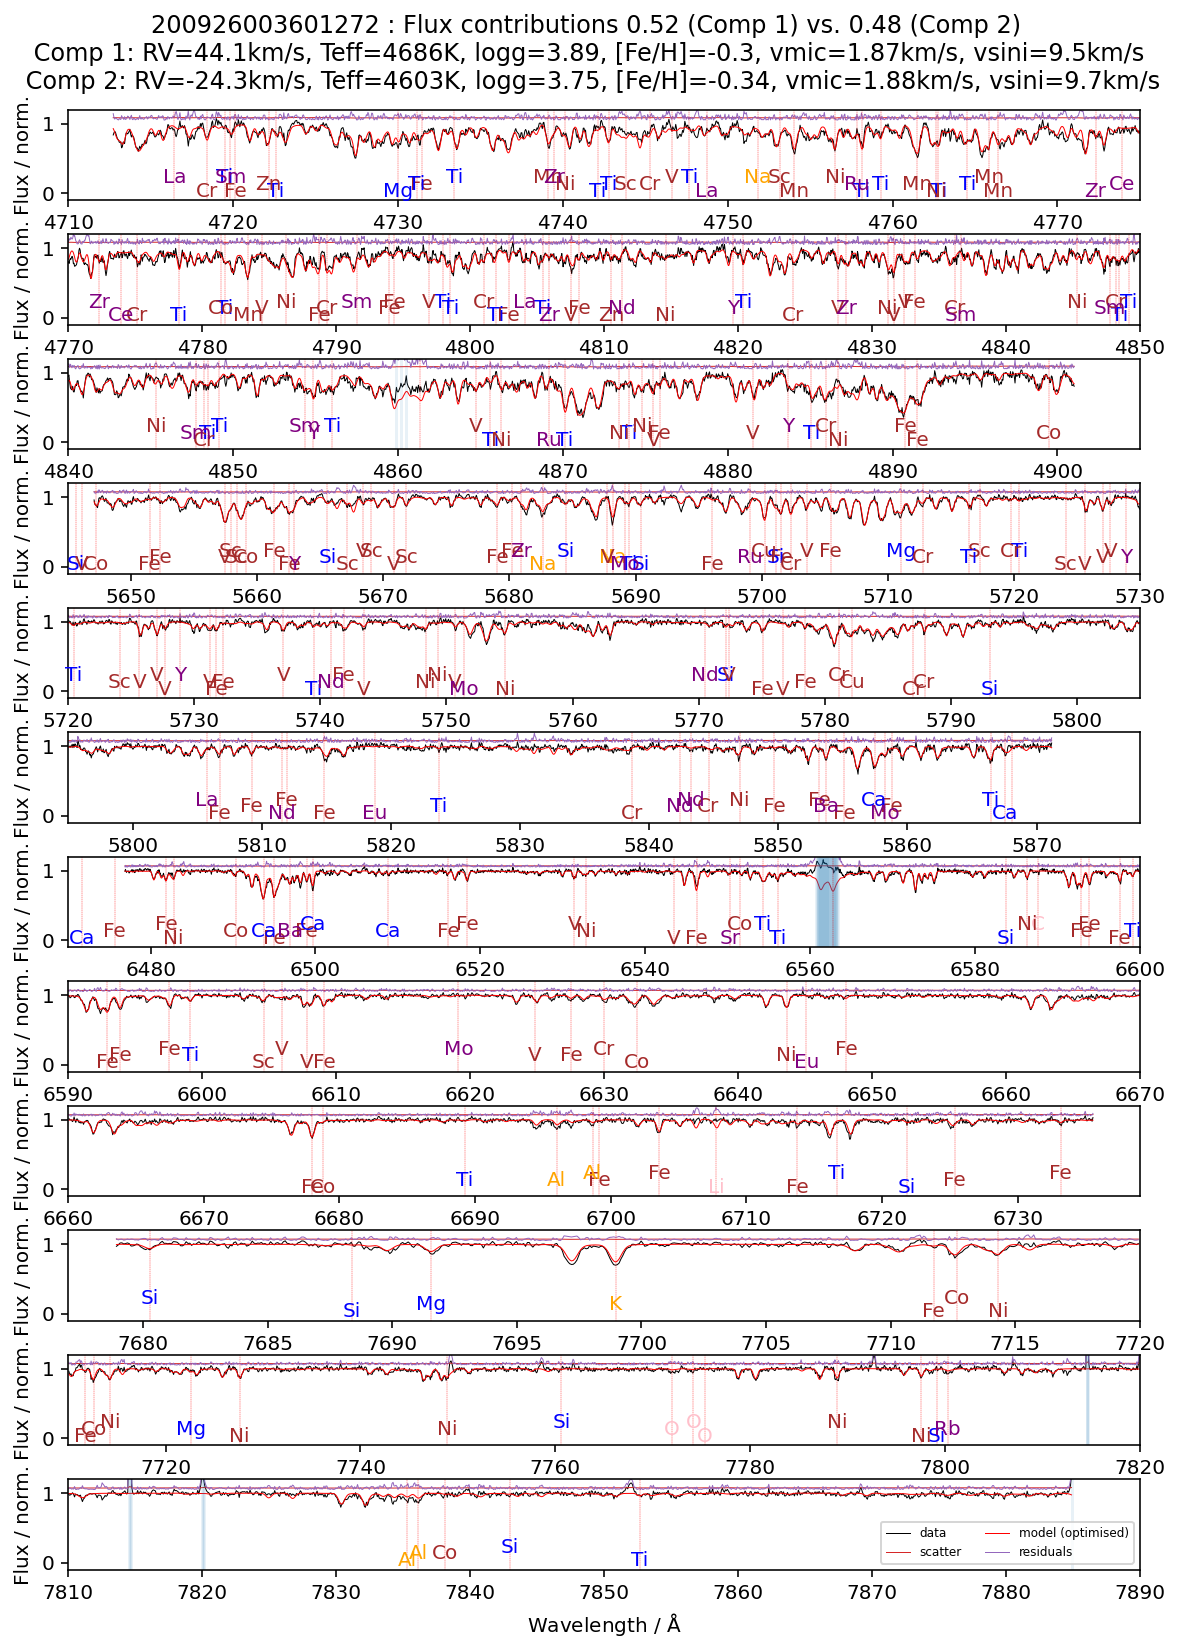

In [27]:
fig = plot_spectrum(
    wave_iter1,
    [
        data_iter1,
        model_iter1
    ],
    np.sqrt(sigma2_iter1),
    ~unmasked_iter1,
    str(sobject_id)+' : Flux contributions '+str(np.round(model_parameters_iter1[model_labels == 'f_contr'][0],decimals=2))+' (Comp 1) vs. '+str(np.round(1-model_parameters_iter1[model_labels == 'f_contr'][0],decimals=2))+' (Comp 2)',
    'Comp 1: RV='+str(np.round(model_parameters_iter1[model_labels == 'rv_1'][0],decimals=1))+'km/s, '+
    'Teff='+str(int(np.round(1000*model_parameters_iter1[model_labels == 'teff_1'][0])))+'K, '+
    'logg='+str(np.round(model_parameters_iter1[model_labels == 'logg_1'][0],decimals=2))+', '+
    '[Fe/H]='+str(np.round(model_parameters_iter1[model_labels == 'fe_h_1'][0],decimals=2))+', '+
    'vmic='+str(np.round(model_parameters_iter1[model_labels == 'vmic_1'][0],decimals=2))+'km/s, '+
    'vsini='+str(np.round(model_parameters_iter1[model_labels == 'vsini_1'][0],decimals=1))+'km/s',
    'Comp 2: RV='+str(np.round(model_parameters_iter1[model_labels == 'rv_2'][0],decimals=1))+'km/s, '+
    'Teff='+str(int(np.round(1000*model_parameters_iter1[model_labels == 'teff_2'][0])))+'K, '+
    'logg='+str(np.round(model_parameters_iter1[model_labels == 'logg_2'][0],decimals=2))+', '+
    '[Fe/H]='+str(np.round(model_parameters_iter1[model_labels == 'fe_h_2'][0],decimals=2))+', '+
    'vmic='+str(np.round(model_parameters_iter1[model_labels == 'vmic_2'][0],decimals=2))+'km/s, '+
    'vsini='+str(np.round(model_parameters_iter1[model_labels == 'vsini_2'][0],decimals=1))+'km/s'
)

file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig.savefig(file_directory+str(spectrum['sobject_id'])+'_binary_fit_comparison.pdf',overwrite=True,bbox_inches='tight')
if sys.argv[1] == '-f':
    plt.show()
plt.close()

# Save results + diagnostic plots

In [28]:
# Save fits_results

output = Table()

#file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)
for label in ['tmass_id']:
    col = Table.Column(
        name=label,
        data = [str(spectrum[label])],
        description=description[label],
        unit=units[label])
    output.add_column(col)
for label in ['gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [int(spectrum[label])],
        description=description[label],
        unit=units[label])
    output.add_column(col)

# flag_sp:
# flag_sp == 1: could not use correct interpolation model
# flag_sp == 2: not all CCDs available
if len(spectrum['available_ccds']) != 4:
    flag_sp += 2

col = Table.Column(
    name='flag_sp',
    data = [int(flag_sp)],
    description=description['flag_sp'],
    unit='')
output.add_column(col)
    
diagonal_covariance_entries_sqrt = np.sqrt(np.diag(covariances_iter1))

# # These are the labels that our interpolation routine was trained on
# model_interpolation_labels = np.array(['teff', 'logg', 'fe_h', 'vmic', 'vsini', 'li_fe', 'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe'])

# # flag_x_fe_values:
# flag_x_fe_value_no_detection = 1
# flag_x_fe_value_not_measured = 2

# # Let's loop through all the parameters that are part of the spectrum_interpolation routine
for label_index, label in enumerate(model_labels):
    
    label_value = model_parameters_iter1[label_index]
    if label in ['teff','teff_1','teff_2']:
        label_value *= 1000
        
    if label[-2:] == '_1':
        description_text = 'Component 1 '+description[label[:-2]]
        unit_label = label[:-2]
    elif label[-2:] == '_2':
        description_text = 'Component 2 '+description[label[:-2]]
        unit_label = label[:-2]
    else:
        description_text = description[label]
        unit_label = label

    col = Table.Column(
        name=label,
        data = [np.float32(label_value)],
        description=description_text,
        unit=units[unit_label])
    output.add_column(col)
    
    label_value = diagonal_covariance_entries_sqrt[label_index]
    if label in ['teff','teff_1','teff_2']:
        label_value *= 1000

    col = Table.Column(
        name='cov_e_'+label,
        data = [np.float32(label_value)],
        description='Diagonal Covariance Error (raw) for '+label,
        unit=units[unit_label])
    output.add_column(col)

# And save!
output.write(file_directory+str(spectrum['sobject_id'])+'_binary_fit_results.fits',overwrite=True)

# Let's check what we got
if sys.argv[1] == '-f':
    output

In [29]:
# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_iter1
save_spectrum['sob'] = data_iter1
save_spectrum['uob'] = np.sqrt(sigma2_iter1)
save_spectrum['smod'] = model_iter1
save_spectrum['mob'] = unmasked_iter1

file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

save_spectrum.write(file_directory+str(spectrum['sobject_id'])+'_binary_fit_spectrum.fits',overwrite=True)

In [30]:
# Save covariances
np.savez(
    file_directory+str(spectrum['sobject_id'])+'_binary_fit_covariances.npz',
    model_labels = model_labels,
    model_parameters_optimised = model_iter1,
    covariances_optimised = covariances_iter1
)

In [31]:
end_time = time.time() - start_time
print('Duration: '+str(np.round(end_time,decimals=1)))

Duration: 40.0
